In [61]:
import pandas as pd

import glob 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import re
import yaml
import numpy as np

## Load the simulation files

- First load the csv with all the properties
- Create a dataframe for labels and scores
- Create plots for all the

In [62]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

In [63]:
simulation_table = pd.read_csv('Tests-list-FL r01.csv')

In [64]:
sim_id_label = list(simulation_table[(simulation_table['Simulation #'] > 20) & (simulation_table['Simulation #'] < 31) ]['Simulation #'].unique())

In [5]:
sim_id_label

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [6]:
directories = glob.glob("toplot/*imulation_*")

In [7]:
def load(conf_file):
    with open(conf_file) as f:
        settings = yaml.safe_load(f)
        return settings


In [8]:
def populate_columns(df,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels):
    df['n_clients'] = n_clients
    df['network_type'] = network_type
    df['random_clients'] = random_clients
    df['n_bits'] = n_bits
    df['sim_n'] = sim_n
    df['block'] = block
    df['frame_size'] = frame_size
    df['n_channels'] = n_channels
    return df

In [9]:
def clean_y(x):
    l = [float(e) for e in x.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
    l_np = np.asarray(l)
    return(l_np.argmax())

In [10]:
def generate_dataframe(d,score_file,event_file,sim_type,df_total,block):
    try: 
        setup = os.path.join(d,setup_file)
        settings = load(setup)
        n_clients = settings['setup']['n_clients']
        network_type = settings['setup']['network_type']
        random_clients = settings['setup']['random_clients']
        n_bits = settings['setup']['n_bits']
        fram_size = 'random'
        if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
        n_channels = 1
        if 'n_channels' in settings['setup'].keys():
            n_channels = settings['setup']['n_channels']

        scores = os.path.join(d,score_file)
        events = os.path.join(d,event_file)
        df_scores = pd.read_csv(scores).drop(columns=['Unnamed: 0'])
        df_events = pd.read_csv(events).drop(columns=['Unnamed: 0'])
        print("scores size: {} {}".format(d,df_scores.shape[0]))
        print("events size: {} {}".format(d,df_events.shape[0]))
        if sim_type == 'score':
            df_scores['y_values'] = df_scores['Y'].str[7:-1]
            df_scores = df_scores.astype({'y_values':float})

        elif sim_type == 'label':
            df_scores['label'] = df_scores.Y.apply(lambda x:clean_y(x))
        df_merged = pd.merge(df_scores,df_events,on='X',how='outer')
        df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n,block,fram_size,n_channels)    
        df_merged.fillna(value={'E':'run'},inplace=True)
        df_merged.fillna(method='ffill')
        print("\t**merged size: {} {}".format(d,df_merged.shape[0]))
        df_total = pd.concat([df_total,df_merged])
        return df_total
    except Exception as e:
        print(e)
        return df_total

In [11]:
df_total_label = pd.DataFrame()

setup_file = "setup_tests.yaml"
label_file = "scoreL.csv"
event_label_file = "eventL.csv"


for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        for i in range(0,5):
            block = os.path.join(d,'block_{}'.format(i))
            df_total_label = generate_dataframe(block,label_file,event_label_file,'label',df_total_label,i)
    else:
        print('problema!')
    

problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_25 is a label simulation
scores size: toplot/Simulation_25/block_0 1600
events size: toplot/Simulation_25/block_0 405
	**merged size: toplot/Simulation_25/block_0 1905
scores size: toplot/Simulation_25/block_1 3200
events size: toplot/Simulation_25/block_1 405
	**merged size: toplot/Simulation_25/block_1 3505
scores size: toplot/Simulation_25/block_2 1600
events size: toplot/Simulation_25/block_2 405
	**merged size: toplot/Simulation_25/block_2 1905
scores size: toplot/Simulation_25/block_3 900
events size: toplot/Simulation_25/block_3 405
	**merged size: toplot/Simulation_25/block_3 1205
scores size: toplot/Simulation_25/block_4 3200
events size: toplot/Simulation_25/block_4 405
	**merged size: toplot/Simulation_25/block_4 3505
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_22 is a label s

problema!
problema!
problema!
problema!


In [12]:
df_total_label.shape

(92850, 12)

### Error rate / Channel capacity plots for label simulations

In [13]:
def clean_bits(x,init_str,n_chars):

    if x is None:
        return 0
    if x.startswith(init_str):
        return int(x[n_chars:])
    return 0
    

In [14]:
df_total_label['success'] = df_total_label.E.apply(lambda x:clean_bits(x,'Succes',26))
df_total_label['error'] = df_total_label.E.apply(lambda x:clean_bits(x,'Error',7))

In [15]:
columns_to_groupby = ['n_clients', 'network_type','random_clients', 'n_bits', 'sim_n','block']

In [16]:
gb_for_error_rate = df_total_label.groupby(columns_to_groupby,as_index=False).agg({'success': 'max', 'error': 'max'})

In [17]:
gb_for_error_rate['error_rate'] =  gb_for_error_rate['error']/(gb_for_error_rate['success'] + gb_for_error_rate['error']) 

### plot error rate bar plot 

In [18]:
gb_for_error_rate = gb_for_error_rate.astype({'sim_n':int})

In [19]:
gb_for_error_rate = gb_for_error_rate.sort_values(by=['sim_n','block'])

In [20]:
gb_for_error_rate[['sim_n']].value_counts()

sim_n
21       5
22       5
23       5
24       5
25       5
26       5
27       5
28       5
29       5
30       5
dtype: int64

In [29]:
# mpl.rc('font',family='Times New Roman')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


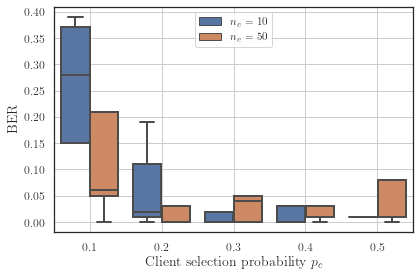

In [289]:
# font = {
#         'color': 'black',
#         'weight': 'normal',
#         'size': 12,
#         }
# sns.set_theme(style="white")
ax = sns.boxplot(x='random_clients', y='error_rate', data=gb_for_error_rate, hue='n_clients', linewidth=2, showfliers=False)
# plt.title('Error rate as function of \n the probability to be selected',fontdict=font,pad=20)
plt.xlabel('Client selection probability $p_c$',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
plt.grid()
plt.tight_layout()
plt.savefig('plots/error-rate-probability_cnn.png', dpi=300)
plt.savefig('plots/error-rate-probability_cnn.svg', dpi=300)
plt.savefig('plots/error-rate-probability_cnn.eps', dpi=300)
plt.savefig('plots/error-rate-probability_cnn.pdf', dpi=300)


### error rate and frame length 
 - box plot frame length

In [27]:
frame_start = df_total_label[df_total_label['E'] == 'Frame start'].copy()

In [28]:
frame_start['n_x'] =  frame_start.groupby(['sim_n','block'])['X'].shift(1)
frame_start['frame_length'] = frame_start['X'] - frame_start['n_x']  

In [29]:
frame_start.dropna(inplace=True)

In [30]:
columns_to_groupby

['n_clients', 'network_type', 'random_clients', 'n_bits', 'sim_n', 'block']

In [31]:
frame_start_dd = frame_start[columns_to_groupby+['frame_length']].drop_duplicates()

In [191]:
frame_start_dd.sim_n.value_counts()

29    5
24    5
23    5
27    5
22    5
26    5
25    5
30    5
28    5
21    5
Name: sim_n, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


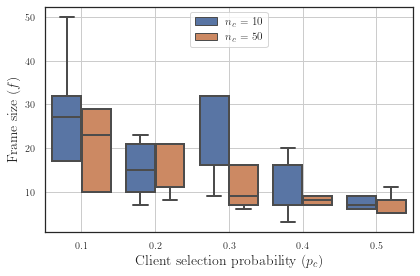

In [323]:
ax = sns.boxplot(x='random_clients', y='frame_length', data=frame_start_dd, hue='n_clients', linewidth=2, showfliers=False)
# plt.title('Error rate as function of \n the probability to be selected',fontdict=font,pad=20)
plt.xlabel('Client selection probability ($p_c$)',fontsize=14)
plt.ylabel('Frame size ($f$)',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ['$n_c$ = 10','$n_c$ = 50'], loc="upper center")
plt.grid()
plt.tight_layout()
plt.savefig('plots/frame_length-probability_cnn.png', dpi=300)
plt.savefig('plots/frame_length-probability_cnn.svg', dpi=300)
plt.savefig('plots/frame_length-probability_cnn.eps', dpi=300)
plt.savefig('plots/frame_length-probability_cnn.pdf', dpi=300)


### error rate and frame length 
 - calcolare lunghezza dei frame
 - scatter plot

## Error rate in time

In [37]:
columns_to_groupby

['n_clients', 'network_type', 'random_clients', 'n_bits', 'sim_n', 'block']

In [38]:
success = df_total_label[df_total_label.E.str.startswith('Successful Transmissions:')][['X']+columns_to_groupby+['success']]

In [39]:
errors = df_total_label[df_total_label.E.str.startswith('Errors:')][['X']+columns_to_groupby+['error']]

In [40]:
success_errors_time = pd.merge(success,errors,on=['X']+columns_to_groupby,how='inner')

success_errors_time['rate'] = success_errors_time['error']/(success_errors_time['error']+success_errors_time['success'])

In [41]:
success_errors_time.head()

,X,n_clients,network_type,random_clients,n_bits,sim_n,block,success,error,rate
0,50,10,CNN,0.3,100,25,0,1,0,0.0
1,66,10,CNN,0.3,100,25,0,2,0,0.0
2,82,10,CNN,0.3,100,25,0,3,0,0.0
3,98,10,CNN,0.3,100,25,0,4,0,0.0
4,114,10,CNN,0.3,100,25,0,5,0,0.0


In [42]:
success_errors_time[['sim_n','block']].value_counts().reset_index().sort_values(by='sim_n')

,sim_n,block,0
0,21,0,100
28,21,2,100
29,21,3,100
30,21,4,100
13,21,1,100
31,22,0,100
32,22,1,100
33,22,2,100
34,22,3,100
35,22,4,100


In [336]:
n_clients = 50
n_bits = 100

cond_gb = (success_errors_time['n_bits']==n_bits) & (success_errors_time['n_clients']==n_clients)


filtered_rate = success_errors_time[cond_gb].sort_values(by='sim_n',ascending=False)
filtered_rate = filtered_rate.astype({'sim_n':int})


In [337]:
filtered_rate.columns

Index(['X', 'n_clients', 'network_type', 'random_clients', 'n_bits', 'sim_n',
       'block', 'success', 'error', 'rate'],
      dtype='object')

In [338]:
filtered_rate = filtered_rate.sort_values(by=['sim_n','block','X'])

In [339]:
filtered_rate['counter'] = filtered_rate.groupby(['sim_n','block']).cumcount()+1


In [341]:
filtered_rate = filtered_rate.sort_values(by=['sim_n','block'])

In [342]:
filtered_rate['toplot'] = filtered_rate['error'] - filtered_rate['error'].shift() 

In [109]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
success_errors_time = success_errors_time.sort_values(by=['sim_n','block','X'])

In [44]:
success_errors_time['counter'] = success_errors_time.groupby(['sim_n','block']).cumcount()+1

In [45]:
success_errors_time = success_errors_time.sort_values(by=['sim_n','block'])

In [46]:
success_errors_time['toplot'] = success_errors_time['error'] - success_errors_time['error'].shift() 

In [114]:
def scatter_plot(filtered_rate,random_clients):

    sel = filtered_rate[(filtered_rate['toplot'] == 1) & (filtered_rate['random_clients'] == random_clients) ]
    print(sel.shape)
    regr = linear_model.LinearRegression()

    X = sel['counter']

    y = sel['error']

    regr.fit(np.array(X).reshape(-1, 1), y)

    regr.coef_

    regr.intercept_

    y_pred = regr.predict(np.array(X).reshape(-1, 1))
    y_pred_2 = regr.predict(np.arange(0,101,1).reshape(-1,1))
    
    r2_score(y,y_pred)


    ax = sns.scatterplot(data=sel, hue='n_clients', x='counter', y='error',marker='x',palette='Set1',s=50)
#     s = plt.scatter(x = sel.counter,y=sel.error,marker='x',c=sel.n_clients,cmap='viridis',label=c)
    plt.plot(np.arange(0,101,1).reshape(-1,1), y_pred_2, color='blue', linewidth=3)
    plt.ylabel('N. of Errors',fontdict=font)
    plt.xlabel('N. of bits sent',fontdict=font)
    handles, _ = ax.get_legend_handles_labels()          
    plt.legend(handles, ['N. of Clients 10','N. of Clients 50'], loc="upper center")
    
    plt.grid()
    plt.ylim((0,25))
    plt.tight_layout()
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.png'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.svg'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.eps'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_hue_cnn.pdf'.format(random_clients), dpi=300)

    plt.show()

In [115]:
def scatter_plot_seaborn(filtered_rate,random_clients):

    sel = filtered_rate[(filtered_rate['toplot'] == 1) & (filtered_rate['random_clients'] == random_clients) ]
    print(sel.shape)
    regr = linear_model.LinearRegression()

    X = sel['counter']

    y = sel['error']

    regr.fit(np.array(X).reshape(-1, 1), y)

    regr.coef_

    regr.intercept_

    y_pred = regr.predict(np.array(X).reshape(-1, 1))
    y_pred_2 = regr.predict(np.arange(0,101,1).reshape(-1,1))
    
    r2_score(y,y_pred)

    ax = sns.regplot(data=sel, x='counter', y='error',marker='+',scatter_kws={'s':100})

#     ax = sns.scatterplot(data=sel, hue='n_clients', x='counter', y='error',marker='x',palette='seismic',s=50)
#     s = plt.scatter(x = sel.counter,y=sel.error,marker='x',c=sel.n_clients,cmap='viridis',label=c)
#     plt.plot(np.arange(0,101,1).reshape(-1,1), y_pred_2, color='blue', linewidth=3)
    plt.ylabel('N. of Errors',fontdict=font)
    plt.xlabel('N. of bits sent',fontdict=font)
#     handles, _ = ax.get_legend_handles_labels()          
#     plt.legend(handles, ['N. of Clients 10','N. of Clients 50'], loc="upper center")
    
#     plt.legend(loc='best')
    plt.grid()
    plt.ylim((0,25))
    plt.savefig('plots/error-rate-scatter_{}_cnn.png'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_cnn.svg'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_cnn.eps'.format(random_clients), dpi=300)
    plt.savefig('plots/error-rate-scatter_{}_cnn.pdf'.format(random_clients), dpi=300)

    plt.show()

0.1
(187, 12)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


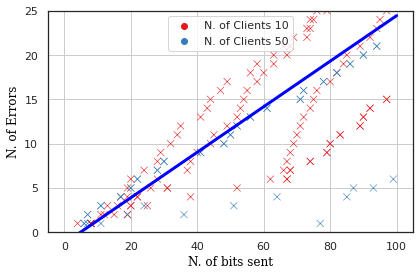

0.2
(41, 12)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


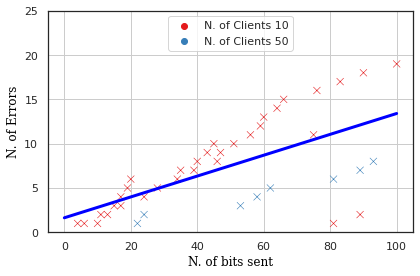

0.3
(21, 12)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


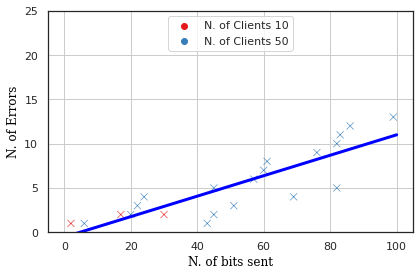

0.4
(45, 12)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


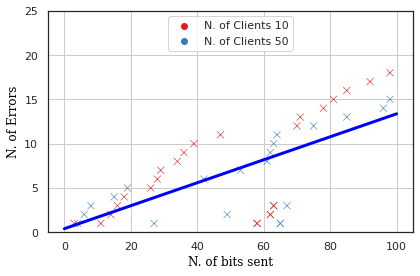

0.5
(25, 12)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


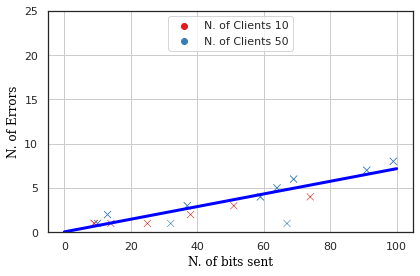

In [116]:
for i in [0.1,0.2,0.3,0.4,0.5]:
    print(i)
    scatter_plot(success_errors_time,i)

In [47]:
success_errors_time['tenth'] = success_errors_time['counter'] // 10

In [48]:
gb_filtered = success_errors_time.groupby(['sim_n','tenth'],as_index=False).agg({'rate':['mean','std'],
                                                                          'sim_n':'first',
                                                                          'network_type':'first',
                                                                          'random_clients':'first',
                                                   'n_bits':'first',
                                                   'n_clients':'first'})

In [49]:
gb_filtered = success_errors_time.groupby(['sim_n','tenth'],as_index=False).agg(
    mean_error = pd.NamedAgg(column='rate', aggfunc='mean'),
    std_error = pd.NamedAgg(column='rate', aggfunc='std'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
)

In [50]:
gb_filtered.head()

,tenth,mean_error,std_error,sim_n,random_clients,network_type,n_bits,n_clients
0,0,0.037866,0.067090,21,0.1,CNN,100,10
1,1,0.113495,0.048579,21,0.1,CNN,100,10
2,2,0.180277,0.063166,21,0.1,CNN,100,10
3,3,0.176310,0.077495,21,0.1,CNN,100,10
4,4,0.168769,0.089252,21,0.1,CNN,100,10


In [121]:
import math

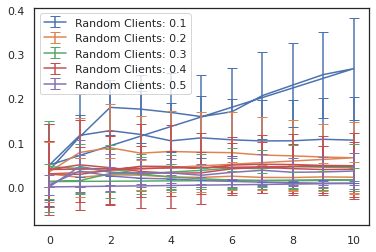

In [194]:
for x,gb in gb_filtered.groupby('random_clients'):
    plt.errorbar(gb.tenth,gb.mean_error,yerr=gb.std_error,
                 barsabove=True,
                 capsize=5,
                 label='Random Clients: {}'.format(x))
plt.legend(loc='best')
plt.show()

In [195]:
success_errors_time.sim_n.unique()

array(['21', '22', '23', '24', '25', '26', '27', '28', '29', '30'],
      dtype=object)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


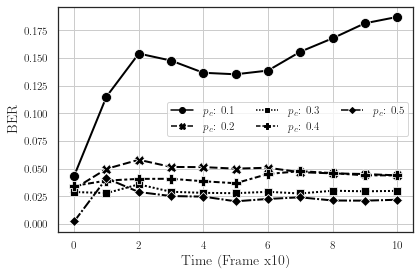

In [288]:
# plt.figure(figsize=(6,5))
ax = sns.lineplot(data=success_errors_time,
                  x="tenth",
                  y="rate",
                  markers=True,
                  dashes=True,
                  hue='random_clients',
                  style='random_clients',
                  palette=['black']*len(success_errors_time.random_clients.unique()),
                  ci=None,
                  linewidth=2,
                markersize=10
                 )
handles, _ = ax.get_legend_handles_labels()

labels = ['$p_c$: {}'.format(v) for v in sorted(success_errors_time.random_clients.unique())]
plt.xlabel('Time (Frame x10)',fontsize=14)
plt.ylabel('BER',fontsize=14)

plt.legend(handles,labels,
           loc='center right',
#            bbox_to_anchor=(0.25, 1.55),
           ncol=3)    
plt.grid()
plt.gray()
plt.tight_layout()

plt.savefig('plots/error-rate_over_time_cnn.png', dpi=300)
plt.savefig('plots/error-rate_over_time_cnn.eps', dpi=300)
plt.savefig('plots/error-rate_over_time_cnn.svg', dpi=300)
plt.savefig('plots/error-rate_over_time_cnn.pdf', dpi=300)
plt.show()

## channel capacity computation

#### Leggere i log e caricarsi la lista di bit inviati/ricevuti e per ogni simulazione, contare:
- bit = 0 inviati
- bit = 1 inviati 
- bit = 0 sbagliati
- bit = 1 sbaglati 

In [ ]:
sim_n = 21

In [80]:
for sim_n in range(21,30):
    for block in range(0,5):
        file_name = 'toplot/Simulation_{}/block_{}/simulazione_{}.out'.format(sim_n,block,sim_n)
        sending = []
        receiving = []
        with open(file_name) as f:
            for l in f:
                if ('Sender: SENDING ' in l ):
                    sending.append(l.strip('\n')[-1:])
                elif ("Receiver: RECEIVED" in l):
                    receiving.append(l.strip('\n')[-1:])
        d = {'sent': sending, 'received': receiving[1:]}
        if len(sending) == 200:
            print(len(sending),len(receiving),sim_n,block)
# df = pd.DataFrame(data=d)


200 202 21 2
200 202 22 3
200 202 23 1
200 202 24 3
200 202 25 3
200 202 26 3
200 202 27 2
200 202 28 3
200 202 29 3


In [65]:
directories = glob.glob("toplot/*imulation_*")

In [66]:
def read_logs(df_total,file_name,setup_file,block):
    sending = []
    receiving = []
    labels_sent = []
    labels_received = []
    with open(file_name) as f:
        for l in f:
            if ('Sender: SENDING ' in l ):
                sending.append(l.strip('\n')[-1:])
            elif ("Receiver: RECEIVED" in l):
                receiving.append(l.strip('\n')[-1:])
            elif ("Sender: frame starts with" in l):
                labels_sent.append(l.strip('\n')[-2:-1])
            elif ("frame ends with" in l):
                labels_received.append(l.strip('\n')[-2:-1])
    print(len(labels_sent),len(labels_received))
    d = {'sent': sending, 'received': receiving[1:],'label_sent':labels_sent,'label_received':labels_received[1:]}
    df = pd.DataFrame(data=d)
    df['error'] = df.apply(lambda x: 1 if x.sent != x.received else 0,axis=1)
    
    settings = load(setup_file)
    n_clients = settings['setup']['n_clients']
    network_type = settings['setup']['network_type']
    random_clients = settings['setup']['random_clients']
    n_bits = settings['setup']['n_bits']
    frame_size = 'random'
    if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
    n_channels = 1
    if 'n_channels' in settings['setup'].keys():
        n_channels = settings['setup']['n_channels']
    df = populate_columns(df,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels)
    
    df_total = pd.concat([df_total,df])
    return df_total

In [192]:
sim_id_label = list(simulation_table[(simulation_table['Simulation #'] > 20) & (simulation_table['Simulation #'] < 30) ]['Simulation #'].unique())

df_total_capacity = pd.DataFrame()

for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        log_file = "simulazione_{}.out".format(sim_n)
        setup_file = "setup_tests.yaml"
        for i in range(0,5):
            block_log = os.path.join(d,'block_{}'.format(i),log_file)
            block_setup_file = os.path.join(d,'block_{}'.format(i),setup_file)
            df_total_capacity = read_logs(df_total_capacity,block_log,block_setup_file,i)
    else:
        print('problema!')
        

problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_25 is a label simulation
100 101
100 101
100 101
100 101
100 101
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_22 is a label simulation
100 101
100 101
100 101
100 101
100 101
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_28 is a label simulation
100 101
100 101
100 101
100 101
100 101
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_26 is a label simulation
100 101
100 101
100 101
100 101
100 101
problema!
problema!
problema!
toplot/Simulation_23 is a label simulation
100 101
100 101
100 101
100 101
100 101
problema!
problema!
problema!
problema!
problema!
problema!
problema!
problema!
toplot/Simulation_21 is a label sim

In [193]:
df_total_capacity.head()

,sent,received,label_sent,label_received,error,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels
0,1,1,8,3,0,10,CNN,0.3,100,25,0,random,1
1,0,0,3,3,0,10,CNN,0.3,100,25,0,random,1
2,1,1,3,8,0,10,CNN,0.3,100,25,0,random,1
3,0,0,8,8,0,10,CNN,0.3,100,25,0,random,1
4,1,1,8,3,0,10,CNN,0.3,100,25,0,random,1


In [194]:
frame_start = df_total_label[df_total_label['E'] == 'Frame start'].copy()

frame_start['n_x'] =  frame_start.groupby(['sim_n','block'])['X'].shift(1)
frame_start['frame_length'] = frame_start['X'] - frame_start['n_x']
frame_start.fillna(method='backfill',inplace=True)

In [195]:
frame_start['offset'] = frame_start.groupby(['sim_n','block'])['X'].transform('first')

In [196]:
frame_start['counter'] = (frame_start.X-frame_start.offset) // frame_start.frame_length 

In [197]:
frame_start_slim = frame_start[['frame_length','offset','sim_n','block']].drop_duplicates().copy()

In [198]:
df_total = pd.merge(df_total_label,frame_start_slim,on=['sim_n','block'],how='inner')

In [199]:
df_total.shape

(92850, 16)

In [200]:
df_total['counter'] = (df_total.X-df_total.offset) // df_total.frame_length 

In [201]:
df_total_capacity['counter'] = df_total_capacity.groupby(['sim_n','block']).cumcount()

In [202]:
gb_df_total = df_total.groupby(['sim_n','block','counter'],as_index=False).agg(
    score_start = pd.NamedAgg(column='Y', aggfunc='first'),
    score_end = pd.NamedAgg(column='Y', aggfunc='last'),
    counter = pd.NamedAgg(column='counter', aggfunc='first'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    block = pd.NamedAgg(column='block', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
    first_x = pd.NamedAgg(column='X', aggfunc='first'),
    last_x = pd.NamedAgg(column='X', aggfunc='last'),
    first_label = pd.NamedAgg(column='label', aggfunc='first'),
    last_label = pd.NamedAgg(column='label', aggfunc='last'),
).dropna()

In [203]:
df_merged_fs_capacity = pd.merge(gb_df_total,df_total_capacity,on=['sim_n','block','counter'],how='inner')

In [204]:
labels_sent = df_merged_fs_capacity.groupby(['sim_n','block'])['label_sent'].unique().reset_index()

In [205]:
labels_sent.head()

,sim_n,block,label_sent
0,21,0,"[8, 3, 1, 7]"
1,21,1,"[8, 3, 5, 1]"
2,21,2,"[8, 3, 1, 7, 0]"
3,21,3,"[8, 3, 5, 1]"
4,21,4,"[8, 3, 7, 1]"


In [206]:
def get_scores(x,labels_sent):
    if 'tensor' in x.score_start:
        l = [float(e) for e in x.score_start.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
        l_np = np.asarray(l)
        sel_labels = labels_sent[(labels_sent['sim_n'] == x.sim_n) & (labels_sent['block'] == x.block) ]
        for el in sorted(sel_labels['label_sent']):
            return l_np[int(el[0])],l_np[int(el[1])]

In [207]:
def get_scores_end(x,labels_sent):
    if 'tensor' in x.score_end:
        l = [float(e) for e in x.score_end.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
        l_np = np.asarray(l)
        sel_labels = labels_sent[(labels_sent['sim_n'] == x.sim_n) & (labels_sent['block'] == x.block) ]
        for el in sorted(sel_labels['label_sent']):
            return l_np[int(el[0])],l_np[int(el[1])]

In [208]:
df_merged_fs_capacity['score_h_s'], df_merged_fs_capacity['score_l_s'] = zip(*df_merged_fs_capacity.apply(lambda x:get_scores(x,labels_sent),axis=1))

In [209]:
df_merged_fs_capacity['score_h_e'], df_merged_fs_capacity['score_l_e'] = zip(*df_merged_fs_capacity.apply(lambda x:get_scores_end(x,labels_sent),axis=1))

In [210]:
cols = ['sent','received','label_sent','label_received','error','score_h_s','score_l_s','score_h_e','score_l_e','first_label','last_label','first_x','last_x'] #+ ['score_{}'.format(i) for i in range(0,10)]

In [211]:
df_merged_fs_capacity['diff'] = df_merged_fs_capacity.score_l_e - df_merged_fs_capacity.score_h_e

In [212]:
df_merged_fs_capacity['diff_expected'] = np.sign(df_merged_fs_capacity['diff'])

In [213]:
def signal_expected(x):
    factor = 1
    if x.error == 1:
        factor = -1
    return factor*x.diff_expected

In [214]:
gb_capacity = df_merged_fs_capacity.loc[df_merged_fs_capacity.groupby(['sim_n','block'])['diff'].idxmax()]

In [215]:
gb_capacity = gb_capacity[['sim_n','block','diff']]

In [216]:
df_merged = pd.merge(df_merged_fs_capacity,gb_capacity,on=['sim_n','block'],how='left')

In [217]:
df_merged['diff_scaled'] = df_merged['diff_x'] / df_merged['diff_y']

In [218]:
df_merged_fs_capacity = df_merged.copy()

In [219]:
df_merged_fs_capacity['diff_expected'] = df_merged_fs_capacity.apply(lambda x:signal_expected(x),axis=1)

In [220]:
df_merged_fs_capacity['rumore'] = df_merged_fs_capacity['diff_scaled'] - df_merged_fs_capacity['diff_expected'] 

In [311]:
gb_rumore = df_merged_fs_capacity.groupby('sim_n',as_index=False)['rumore'].std()

merged_rumore_std = pd.merge(df_merged_fs_capacity,gb_rumore,on='sim_n')

merged_rumore_std.columns

merged_rumore_std['snr'] = merged_rumore_std['diff_scaled']**2 / merged_rumore_std['rumore_y'].std()**2

merged_rumore_std['snr'] = merged_rumore_std['snr'].apply(lambda x:10*math.log10(x))

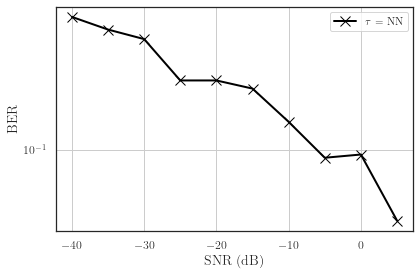

In [313]:
bins = np.arange(-40,15,5)

labels = [b for b in bins]

merged_rumore_std['binned'] = pd.cut(merged_rumore_std['snr'], bins=bins,labels=labels[:-1])

test = merged_rumore_std.groupby(['binned'],as_index=False).agg(
    error_sum = pd.NamedAgg(column='error', aggfunc='sum'),
    bit_sent = pd.NamedAgg(column='error', aggfunc='count'))

test['error_rate'] = test['error_sum'] / test['bit_sent']
test.dropna(inplace=True)
test = test.sort_values('binned')

plt.plot(test.binned,test.error_rate,'x-',c='black',label=r'$\tau$ = NN',linewidth=2,markersize=10)
# plt.plot(test_cnn.binned,test_cnn.error_rate,'^--',c='black',label=r'$\tau$ = CNN',linewidth=2,markersize=10)
plt.xlabel('SNR (dB)',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='best')
plt.yscale('log')

plt.tight_layout()

# plt.savefig('plots/snr_ber.png', dpi=300)
# plt.savefig('plots/snr_ber.eps', dpi=300)
# plt.savefig('plots/snr_ber.svg', dpi=300)
# plt.savefig('plots/snr_ber.pdf', dpi=300)
plt.show()

In [314]:
test.to_csv('snr_ber_cnn.csv')

In [221]:
df_merged_fs_capacity['snr'] = df_merged_fs_capacity['diff_scaled']**2 / df_merged_fs_capacity['rumore'].std()**2

In [222]:
df_merged_fs_capacity['snr'] = df_merged_fs_capacity['snr'].apply(lambda x:10*math.log10(x))

In [223]:
df_merged_fs_capacity = df_merged_fs_capacity[df_merged_fs_capacity.rumore != 0].copy()

In [224]:
bins = np.arange(-40,10,5)

labels = [b for b in bins]

In [225]:
df_merged_fs_capacity['binned'] = pd.cut(df_merged_fs_capacity['snr'], bins=bins,labels=labels[:-1])

In [226]:
test = df_merged_fs_capacity.groupby(['binned'],as_index=False).agg(
    error_sum = pd.NamedAgg(column='error', aggfunc='sum'),
    bit_sent = pd.NamedAgg(column='error', aggfunc='count'))

In [227]:
test['error_rate'] = test['error_sum'] / test['bit_sent']

In [228]:
test = test.sort_values('binned')

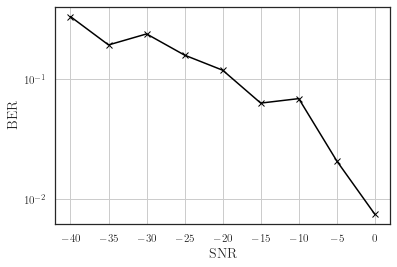

In [229]:
plt.plot(test.binned,test.error_rate,'x-',c='black')
plt.ylabel('BER',fontsize=14)
plt.xlabel('SNR',fontsize=14)
plt.grid()
plt.yscale('log')

In [230]:
test.to_csv('snr_ber_cnn.csv')

In [231]:
gb_per_bit = df_total_capacity.groupby(['sim_n','block','sent'],as_index=False).agg(
    errors = pd.NamedAgg(column='error', aggfunc='sum'),
    total_sent = pd.NamedAgg(column='sent', aggfunc='count'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    random_clients = pd.NamedAgg(column='random_clients', aggfunc='first'),
    network_type = pd.NamedAgg(column='network_type', aggfunc='first'),
    n_bits = pd.NamedAgg(column='n_bits', aggfunc='first'),
    n_clients = pd.NamedAgg(column='n_clients', aggfunc='first'),
)

In [232]:
gb_per_bit.head()

,block,sent,errors,total_sent,sim_n,random_clients,network_type,n_bits,n_clients
0,0,0,16,57,21,0.1,CNN,100,10
1,0,1,21,43,21,0.1,CNN,100,10
2,1,0,3,48,21,0.1,CNN,100,10
3,1,1,12,52,21,0.1,CNN,100,10
4,2,0,15,48,21,0.1,CNN,100,10


In [233]:
gb_per_bit_0 = gb_per_bit[gb_per_bit['sent'] == '0'].drop(columns=['sent']).copy()
gb_per_bit_1 = gb_per_bit[gb_per_bit['sent'] == '1'].drop(columns=['sent']).copy()

In [234]:
gb_per_bit_0.rename(columns={'total_sent':'total_sent_0','errors':'errors_0'},inplace=True)
gb_per_bit_1.rename(columns={'total_sent':'total_sent_1','errors':'errors_1'},inplace=True)

In [235]:
sim_with_error_per_bit = pd.merge(gb_per_bit_0,gb_per_bit_1,on=['block','sim_n','random_clients','network_type','n_bits','n_clients'])

In [236]:
sim_with_error_per_bit.head()

,block,errors_0,total_sent_0,sim_n,random_clients,network_type,n_bits,n_clients,errors_1,total_sent_1
0,0,16,57,21,0.1,CNN,100,10,21,43
1,1,3,48,21,0.1,CNN,100,10,12,52
2,2,15,48,21,0.1,CNN,100,10,24,52
3,3,3,48,21,0.1,CNN,100,10,12,52
4,4,7,54,21,0.1,CNN,100,10,21,46


In [237]:
def get_capacity(x):
    capacity_0 = 0.5*(x.error_rate_0 + (1- x.error_rate_0)*math.log2(1- x.error_rate_0))
    capacity_1 = 0.5*(x.error_rate_1 + (1- x.error_rate_1)*math.log2(1- x.error_rate_1))
    return 1 + capacity_0 + capacity_1

In [238]:
sim_with_error_per_bit['error_rate_0'] = sim_with_error_per_bit.errors_0 / sim_with_error_per_bit.total_sent_0 

In [239]:
sim_with_error_per_bit['error_rate_1'] = sim_with_error_per_bit.errors_1 / sim_with_error_per_bit.total_sent_1

In [240]:
sim_with_error_per_bit['error_rate_1'].mean()

0.11639882301059762

In [241]:
import math

In [242]:
sim_with_error_per_bit['capacity'] = sim_with_error_per_bit.apply(lambda x:get_capacity(x),axis=1)

In [243]:
sim_with_error_per_bit['error_rate'] = (sim_with_error_per_bit.errors_0 + sim_with_error_per_bit.errors_1)/(sim_with_error_per_bit.total_sent_0 + sim_with_error_per_bit.total_sent_1) 

In [244]:
sim_with_error_per_bit.sim_n.value_counts()

24    5
23    5
27    5
22    5
29    5
28    5
25    5
26    5
21    5
Name: sim_n, dtype: int64

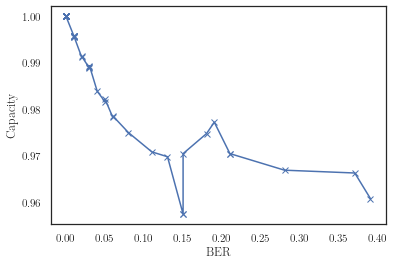

In [245]:
plt.plot(sim_with_error_per_bit.sort_values(by='error_rate',ascending=False).error_rate,sim_with_error_per_bit.sort_values(by='error_rate',ascending=False).capacity,'x-')
# plt.ylim([0,1])
plt.xlabel('BER')
plt.ylabel('Capacity')
plt.show()

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


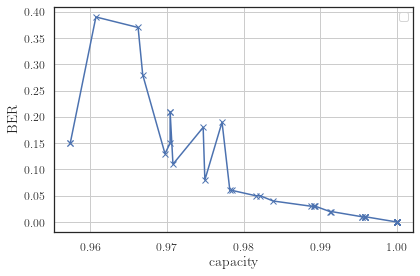

In [287]:
plt.plot(sim_with_error_per_bit.sort_values(by='capacity',ascending=False).capacity,sim_with_error_per_bit.sort_values(by='capacity',ascending=False).error_rate,'x-')
plt.xlabel('capacity',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')

plt.tight_layout()
plt.savefig('plots/cap_ber_cnn.png', dpi=300)
plt.savefig('plots/cap_ber_cnn.eps', dpi=300)
plt.savefig('plots/cap_ber_cnn.svg', dpi=300)
plt.savefig('plots/cap_ber_cnn.pdf', dpi=300)

In [247]:
gb_snr = df_merged_fs_capacity.groupby(['sim_n','block'],as_index=False).agg(
    snr_avg = pd.NamedAgg(column='snr', aggfunc='mean'),
    sim_n = pd.NamedAgg(column='sim_n', aggfunc='first'),
    block = pd.NamedAgg(column='block', aggfunc='first'),
)

In [248]:
merged_capacity_snr = pd.merge(gb_snr,sim_with_error_per_bit,on=['sim_n','block'])

In [338]:
bins = np.arange(-40,15,7)

labels = [b for b in bins]

merged_capacity_snr['binned'] = pd.cut(merged_capacity_snr['snr_avg'], bins=bins,labels=labels[:-1])

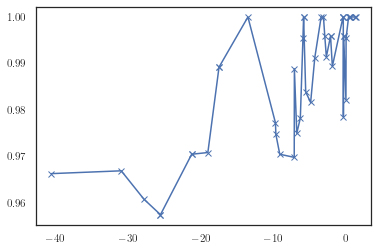

In [339]:
plt.plot(merged_capacity_snr.sort_values(by='snr_avg',ascending=False).snr_avg,merged_capacity_snr.sort_values(by='snr_avg',ascending=False).capacity,'x-')
# plt.ylim([0,1])
plt.show()

In [340]:
binned = merged_capacity_snr.groupby(['binned'],as_index=False).agg({'capacity':'mean'})

In [341]:
binned

,binned,capacity
0,-40,NaN
1,-33,0.963806
2,-26,0.963919
3,-19,0.987298
4,-12,0.983040
5,-5,0.995171
6,2,NaN


(array([ 1.,  0.,  1.,  3.,  2.,  3.,  1.,  5., 11., 18.]),
 array([-40.51906667, -36.32940947, -32.13975227, -27.95009507,
        -23.76043787, -19.57078068, -15.38112348, -11.19146628,
         -7.00180908,  -2.81215188,   1.37750532]),
 <BarContainer object of 10 artists>)

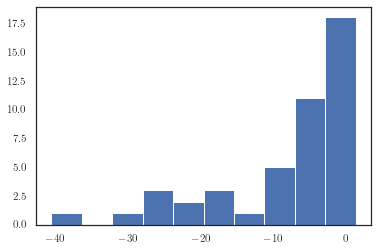

In [342]:
plt.hist(merged_capacity_snr.snr_avg)

In [343]:
binned.dropna(inplace=True)

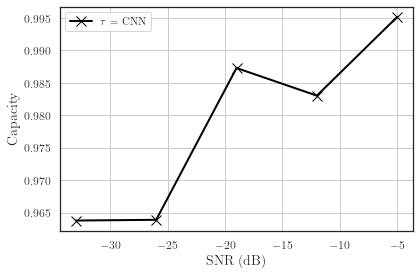

In [344]:
plt.plot(binned.binned,binned.capacity,'x-',c='black',label=r'$\tau$ = CNN',linewidth=2,markersize=10)
# plt.plot(test_cnn.binned,test_cnn.error_rate,'^--',c='black',label=r'$\tau$ = CNN',linewidth=2,markersize=10)
plt.xlabel('SNR (dB)',fontsize=14)
plt.ylabel('Capacity',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')

plt.tight_layout()

In [345]:
binned.to_csv('binned_cnn.csv',index=False)

In [53]:
def generate_dataframe(d,score_file,event_file,sim_type,df_total,block):
    try: 
        setup = os.path.join(d,setup_file)
        settings = load(setup)
        n_clients = settings['setup']['n_clients']
        network_type = settings['setup']['network_type']
        random_clients = settings['setup']['random_clients']
        n_bits = settings['setup']['n_bits']
        frame_size = 'random'
        if 'frame_size' in settings['setup'].keys():
            frame_size = settings['setup']['frame_size']
        
        n_channels = 1
        if 'n_channels' in settings['setup'].keys():
            n_channels = settings['setup']['n_channels']
        
        scores = os.path.join(d,score_file)
        events = os.path.join(d,event_file)
        df_scores = pd.read_csv(scores).drop(columns=['Unnamed: 0'])
        df_events = pd.read_csv(events).drop(columns=['Unnamed: 0'])
        print("scores size: {} {}".format(d,df_scores.shape[0]))
        print("events size: {} {}".format(d,df_events.shape[0]))
        if sim_type == 'score':
            df_scores['y_values'] = df_scores['Y'].str[7:-1]
            df_scores = df_scores.astype({'y_values':float})

#         elif sim_type == 'label':
#             df_scores['label'] = df_scores.Y.apply(lambda x:clean_y(x))
        df_merged = pd.merge(df_scores,df_events,on='X',how='outer')
        df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels)    
        df_merged.fillna(value={'E':'run'},inplace=True)
        df_merged.fillna(method='ffill')
        print("\t**merged size: {} {}".format(d,df_merged.shape[0]))
        df_total = pd.concat([df_total,df_merged])
        return df_total
    except Exception as e:
        print(e)
        return df_total

In [54]:
sim_id_label = list(simulation_table[(simulation_table['Simulation #'] > 80) & (simulation_table['Simulation #'] < 101) ]['Simulation #'].unique())

df_total_channel = pd.DataFrame()

setup_file = "setup_tests.yaml"
label_file = "scoreL.csv"
event_label_file = "eventL.csv"


for d in directories:
    name,sim_n = d.split('_')
    if int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        block = os.path.join(d,'block_{}'.format(0))
        df_total_channel = generate_dataframe(block,label_file,event_label_file,'label',df_total_channel,i)
    else:
        print('problema! {}'.format(int(sim_n)))

problema! 74
problema! 112
problema! 102
toplot/Simulation_97 is a label simulation
scores size: toplot/Simulation_97/block_0 800
events size: toplot/Simulation_97/block_0 605
	**merged size: toplot/Simulation_97/block_0 1205
toplot/Simulation_96 is a label simulation
scores size: toplot/Simulation_96/block_0 800
events size: toplot/Simulation_96/block_0 605
	**merged size: toplot/Simulation_96/block_0 1205
toplot/Simulation_81 is a label simulation
scores size: toplot/Simulation_81/block_0 800
events size: toplot/Simulation_81/block_0 605
	**merged size: toplot/Simulation_81/block_0 1205
problema! 106
problema! 1
problema! 25
problema! 111
problema! 121
toplot/Simulation_94 is a label simulation
scores size: toplot/Simulation_94/block_0 800
events size: toplot/Simulation_94/block_0 605
	**merged size: toplot/Simulation_94/block_0 1205
problema! 120
problema! 71
problema! 116
problema! 64
problema! 119
problema! 101
problema! 67
problema! 117
toplot/Simulation_98 is a label simulation


In [55]:
success = df_total_channel[(df_total_channel['E'].str.startswith('FINAL SUCCESSFUL')) ].copy()

def clean_multi(x):
    return int(x.split(': ')[1])

success['success_bits'] = success['E'].apply(lambda x: clean_multi(x))

errors = df_total_channel[(df_total_channel['E'].str.startswith('FINAL ERROR')) ].copy()

errors['errors_bits'] = errors['E'].apply(lambda x: clean_multi(x))

errors.head(1)

errors = errors[['X','errors_bits','sim_n','block']].copy()

df_error_rates = pd.merge(success,errors,on=['X','sim_n','block'])

df_error_rates = df_error_rates.sort_values(by=['sim_n','block'])

df_error_rates['error_rate'] = df_error_rates.errors_bits / (df_error_rates.errors_bits + df_error_rates.success_bits) 

In [56]:
df_error_rates.shape

(20, 14)

In [57]:
df_error_rates = df_error_rates.sort_values('sim_n')

In [58]:
df_error_rates.head()

,X,Y,E,n_clients,network_type,random_clients,n_bits,sim_n,block,frame_size,n_channels,success_bits,errors_bits,error_rate
7,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 1471,10,CNN,0.5,100,100,4,8,20,1471,529,0.2645
2,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 100,10,CNN,0.5,100,81,4,8,1,100,0,0.0000
5,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 193,10,CNN,0.5,100,82,4,8,2,193,7,0.0350
14,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 291,10,CNN,0.5,100,83,4,8,3,291,9,0.0300
19,802,NaN,FINAL SUCCESSFUL TRANSMISSIONS: 383,10,CNN,0.5,100,84,4,8,4,383,17,0.0425


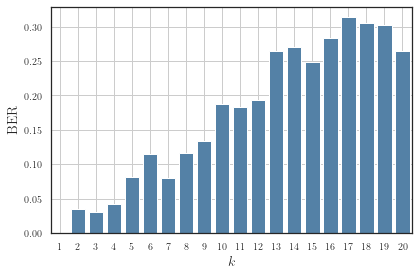

In [60]:
sns.barplot(x='n_channels',y='error_rate',data=df_error_rates,color='steelblue')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('BER',fontsize=14)

# plt.legend(loc='upper left',
# #            bbox_to_anchor=(0.25, 1.55),
#            ncol=2,
#            prop={'family':font['family']})    
plt.grid()
plt.gray()
plt.tight_layout()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('plots/error-rate-probability-multi_cnn.png', dpi=300)
plt.savefig('plots/error-rate-probability-multi_cnn.eps', dpi=300)
plt.savefig('plots/error-rate-probability-multi_cnn.svg', dpi=300)
plt.savefig('plots/error-rate-probability-multi_cnn.pdf', dpi=300)
plt.show()

In [788]:
gb_per_bit.pivot(index=['block','sim_n','random_clients','network_type','n_bits','n_clients'],columns=['sent'],values=['total_sent','errors']).reset_index()

index block sim_n random_clients network_type n_bits n_clients  \
sent                                                                  
0        0     0     1            0.1           NN    100        10   
1        1     0    10            0.5           NN    100        50   
2        2     0     2            0.1           NN    100        50   
3        3     0     3            0.2           NN    100        10   
4        4     0     4            0.2           NN    100        50   
5        5     0     5            0.3           NN    100        10   
6        6     0     6            0.3           NN    100        50   
7        7     0     7            0.4           NN    100        10   
8        8     0     8            0.4           NN    100        50   
9        9     0     9            0.5           NN    100        10   
10      10     1     1            0.1           NN    100        10   
11      11     1    10            0.5           NN    100        50   
12      12     1     2            0.1           NN    100        50   
13      13     1     3            0.2           NN    100        10   
14      14     1     4            0.2           NN    100        50   
15      15     1     5            0.3           NN    100        10   
16      16     1     6            0.3           NN    100        50   
17      17     1     7            0.4           NN    100        10   
18      18     1     8            0.4           NN    100        50   
19      19     1     9            0.5           NN    100        10   
20      20     2     1            0.1           NN    100        10   
21      21     2    10            0.5           NN    100        50   
22      22     2     2            0.1           NN    100        50   
23      23     2     3            0.2           NN    100        10   
24      24     2     4            0.2           NN    100        50   
25      25     2     5            0.3           NN    100        10   
26      26     2     6            0.3           NN    100        50   
27      27     2     7            0.4           NN    100        10   
28      28     2     8            0.4           NN    100        50   
29      29     2     9            0.5           NN    100        10   
30      30     3     1            0.1           NN    100        10   
31      31     3    10            0.5           NN    100        50   
32      32     3     2            0.1           NN    100        50   
33      33     3     3            0.2           NN    100        10   
34      34     3     4            0.2           NN    100        50   
35      35     3     5            0.3           NN    100        10   
36      36     3     6            0.3           NN    100        50   
37      37     3     7            0.4           NN    100        10   
38      38     3     8            0.4           NN    100        50   
39      39     3     9            0.5           NN    100        10   
40      40     4     1            0.1           NN    100        10   
41      41     4    10            0.5           NN    100        50   
42      42     4     2            0.1           NN    100        50   
43      43     4     3            0.2           NN    100        10   
44      44     4     4            0.2           NN    100        50   
45      45     4     5            0.3           NN    100        10   
46      46     4     6            0.3           NN    100        50   
47      47     4     7            0.4           NN    100        10   
48      48     4     8            0.4           NN    100        50   
49      49     4     9            0.5           NN    100        10   

     total_sent     errors      
sent          0   1      0   1  
0            51  49      4   6  
1            56  44      0   0  
2            54  46      0   0  
3            46  54      3   4  
4            57  43      0   4  
5            47  53      0   8  
6            54  46      0   1  
7            53

In [773]:
gb_per_bit[gb_per_bit['sent'] == '1'].total_sent.sum()

2524

In [733]:
df.error.sum()

10

In [734]:
gb_for_error_rate[gb_for_error_rate['sim_n'] == 1 ]

,n_clients,network_type,random_clients,n_bits,sim_n,block,success,error,error_rate
0,10,NN,0.1,100,1,0,90,10,0.10
1,10,NN,0.1,100,1,1,97,3,0.03
2,10,NN,0.1,100,1,2,89,11,0.11
3,10,NN,0.1,100,1,3,84,16,0.16
4,10,NN,0.1,100,1,4,87,13,0.13


## Error rate in time for score attack


In [510]:
success = df_total_score[df_total_score.E.str.startswith('Successful Transmissions:')][['X']+columns_to_groupby+['success']]

In [511]:
errors = df_total_score[df_total_score.E.str.startswith('Errors:')][['X']+columns_to_groupby+['error']]

In [512]:
success_errors_time = pd.merge(success,errors,on=['X']+columns_to_groupby,how='inner')

success_errors_time['rate'] = success_errors_time['error']/(success_errors_time['error']+success_errors_time['success'])

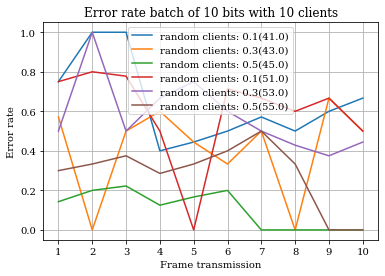

In [516]:
n_clients = 10
n_bits = 10

cond_gb = (success_errors_time['n_bits']==n_bits) & (success_errors_time['n_clients']==n_clients)

filtered_rate = success_errors_time[cond_gb].sort_values(by='sim_n',ascending=False)
filtered_rate = filtered_rate.astype({'sim_n':float})
filtered_rate.sort_values('sim_n')
for key, grp in filtered_rate.groupby(['sim_n']):
    
    label = 'random clients: {}({})'.format(grp.random_clients.iloc[0],grp.sim_n.iloc[0])
    groups = n_bits // 10
    bit_group = grp.groupby(np.arange(len(grp))//groups).agg(lambda x: {'success': x.success.sum(), 
                                                 'error': x.error.sum(),
                                                  'sim_n':x.sim_n.iloc[0],
                                                  'network_type':x.network_type.iloc[0],
                                                   'random_clients':x.random_clients.iloc[0],
                                                   'n_bits':x.n_bits.iloc[0],
                                                   'n_clients':x.n_clients.iloc[0]
                                                  })
    bit_group['rate'] = bit_group.error / (bit_group.success + bit_group.error) 
    plt.plot(range(len(bit_group)), bit_group.rate, label=label)
plt.title('Error rate batch of 10 bits with {} clients'.format(n_clients) )
plt.xticks(range(0,10),range(1,11))
plt.legend(loc='best')
plt.xlabel('Frame transmission')
plt.ylabel('Error rate')
plt.grid()
plt.show()

## count the number of error for 0 / 1

In [350]:
frames = df_total_label[df_total_label['E']=='Frame start'].copy()

In [388]:
frames['prev_label'] = frames.groupby('sim_n')['label'].shift(1)

In [393]:
frames[frames.sim_n == '5'].shape

(100, 12)

In [394]:
def get_bit(x):
    if x.label == x.prev_label:
        return 0
    else:
        return 1

In [395]:
frames['bit_sent'] = frames.apply(lambda x: get_bit(x),axis=1)

In [396]:
frames.head()

,X,Y,label,E,n_clients,network_type,random_clients,n_bits,sim_n,success,error,prev_label,bit_sent
1,44,"tensor([[ -2.5534, -3.8009, -4.3930, 20.628...",8.0,Frame start,10,NN,0.3,100,5,0,0,NaN,1
25,65,"tensor([[ -2.3878, 0.1839, -8.0644, 18.086...",3.0,Frame start,10,NN,0.3,100,5,0,0,8.0,1
49,86,"tensor([[ -2.5296, 0.2453, -7.5033, 17.867...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0
73,107,"tensor([[ -2.5355, 0.9111, -8.4030, 16.320...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0
97,128,"tensor([[ -2.6219, 0.7924, -8.7215, 17.119...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0


In [399]:
_test = pd.merge(df_total_label,frames[['sim_n','X','bit_sent']],on=['sim_n','X'],how='left')

In [418]:
errors = _test[_test['E'].str.contains('Errors:')][['n_clients','network_type','random_clients','n_bits','sim_n','error','bit_sent']]

In [420]:
errors['previous_error'] = errors.groupby('sim_n')['error'].shift(1)

In [425]:
errors[(errors.error - errors.previous_error)>0].bit_sent.value_counts()

0.0    44
1.0     8
Name: bit_sent, dtype: int64

In [400]:
_test.to_csv('test.csv',index=False)

### plot label transmission

In [401]:
settings = load('../label_test/Simulation_46/setup_tests.yaml')

In [402]:
n_clients = settings['setup']['n_clients']
network_type = settings['setup']['network_type']
random_clients = settings['setup']['random_clients']
n_bits = settings['setup']['n_bits']

df_scores = pd.read_csv('../label_test/Simulation_46/scoreL.csv').drop(columns=['Unnamed: 0'])
df_events = pd.read_csv('../label_test/Simulation_46/eventL.csv').drop(columns=['Unnamed: 0'])
print("scores size: {} {}".format(d,df_scores.shape[0]))
print("events size: {} {}".format(d,df_events.shape[0]))
df_merged = pd.merge(df_scores,df_events,on='X',how='outer')

df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n)


scores size: Simulation_55 430
events size: Simulation_55 45


In [403]:
import numpy as np

In [404]:
def clean_y(x):
    print(x)
    l = [float(e) for e in x.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
    l_np = np.asarray(l)
    return(l_np.argmax())

In [405]:
df_merged.fillna(value={'E':'run'},inplace=True)

In [406]:
df_merged.fillna(method='ffill',inplace=True)

In [407]:
df_merged = df_merged.sort_values(by='X')

In [408]:
df_merged.head()

,X,Y,E,n_clients,network_type,random_clients,n_bits,sim_n
458,2,"tensor([[-0.2476, -1.0197, -1.4544, 10.7247, -...",Receiver added,10,NN,0.1,10,55
0,88,"tensor([[ -2.6168, -3.7392, -5.0046, 20.414...",Sender added,10,NN,0.1,10,55
1,88,"tensor([[ -2.6168, -3.7392, -5.0046, 20.414...",Frame start,10,NN,0.1,10,55
2,89,"tensor([[ -2.8459, -3.6503, -4.8449, 20.647...",run,10,NN,0.1,10,55
3,90,"tensor([[ -3.2668, -3.2003, -4.6614, 21.257...",run,10,NN,0.1,10,55


In [409]:
df_merged['label'] = df_merged.Y.apply(lambda x:clean_y(x))

tensor([[-0.2476, -1.0197, -1.4544, 10.7247, -7.2667, -9.3813, -4.9705,  2.8151,
         13.8809, -3.2011]])
tensor([[ -2.6168,  -3.7392,  -5.0046,  20.4145, -10.9762,  -1.8441, -14.5304,
         -16.3034,  24.2172,  10.8751]])
tensor([[ -2.6168,  -3.7392,  -5.0046,  20.4145, -10.9762,  -1.8441, -14.5304,
         -16.3034,  24.2172,  10.8751]])
tensor([[ -2.8459,  -3.6503,  -4.8449,  20.6478, -10.7497,  -1.9513, -14.6445,
         -16.2913,  24.1501,  10.6700]])
tensor([[ -3.2668,  -3.2003,  -4.6614,  21.2578, -11.0704,  -1.8599, -14.7144,
         -16.2671,  24.0593,  10.2406]])
tensor([[ -3.1273,  -3.4446,  -4.0442,  21.4171, -11.2315,  -2.1156, -15.0987,
         -16.4170,  24.0455,  10.5139]])
tensor([[ -3.0076,  -3.6575,  -4.4109,  21.0476, -10.8071,  -2.2050, -14.9272,
         -16.3061,  24.1001,  10.6549]])
tensor([[ -3.0872,  -3.5115,  -4.0418,  21.3579, -11.0425,  -2.2399, -15.1053,
         -16.4758,  24.0208,  10.6133]])
tensor([[ -3.1749,  -3.7327,  -4.3673,  21.3080, -

In [410]:
frames = df_merged[df_merged['E']=='Frame start'].copy()

In [411]:
frames['text'] = frames.label == frames.label.shift(1)

In [413]:
frames.shape

(10, 10)

In [166]:
frames['position'] = (frames.X + frames.X.shift(1))/2

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


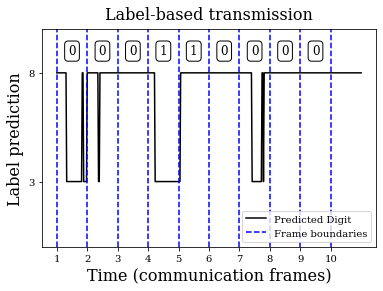

In [192]:

plt.plot(df_merged.iloc[1:,:].X,df_merged.iloc[1:,:]['label'],c='black',label='Predicted Digit')


plt.axvline(x=frames.X.iloc[0],ls='dashed',color='b',label='Frame boundaries')

for i,row in frames.iloc[1:,:].iterrows():
    plt.axvline(x=row.X,ls='dashed',color='b')
    

for i,row in frames.iterrows():
    text = '1'
    if row.text:
        text = '0'
    plt.text(row.position,9,text,family='serif',fontsize=12,ha="center", va="center",bbox=dict(boxstyle="round",fc='white'))


plt.xticks(frames.X,range(1,11),fontname='serif')
plt.yticks([3,8],[3,8],fontname='serif')
plt.ylim((0,10))
plt.title('Label-based transmission',fontdict=font,pad=10)
plt.xlabel('Time (communication frames)',fontdict=font)
plt.ylabel('Label prediction',fontdict=font)
plt.legend(loc ='lower right')
plt.savefig('label-based-transmission.png', dpi=300)
plt.savefig('label-based-transmission.svg', dpi=300)
plt.savefig('label-based-transmission.eps', dpi=300)
plt.savefig('label-based-transmission.pdf', dpi=300)

plt.show()

In [146]:
distinct.head(30)

,X,label
458,2,8
0,88,8
2,89,8
3,90,8
4,91,8
5,92,8
6,93,8
7,94,8
8,95,8
9,96,8


In [125]:
distinct.to_csv('test_label.csv',index=False)

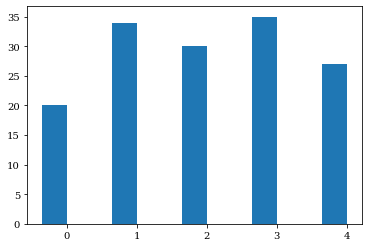

In [279]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 =  plt.bar(x - width/2, men_means, width, label='Men')
